In [163]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch
from fcmeans import FCM
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import mixed_precision
import os
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

In [164]:

gpus = tf.config.experimental.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, False)

# Enable XLA (fuses kernels)
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'
tf.config.optimizer.set_jit(True)

# 2) Enable mixed-precision for Tensor Cores on the T4
mixed_precision.set_global_policy('mixed_float16')
print("Compute dtype:", mixed_precision.global_policy().compute_dtype)
print("Variable dtype:", mixed_precision.global_policy().variable_dtype)

print("GPUs available:", tf.config.list_physical_devices('GPU'))
!nvidia-smi                              # shows GPU status and memory

Compute dtype: float16
Variable dtype: float32
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Thu May  8 19:51:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|         

In [165]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Configuration
# Configuration
DATA_PATH = '/content/drive/MyDrive/Cluster_4342/diabetes_data.csv'
FEATURES = [
    'Age','Sex','HighChol','CholCheck','BMI','Smoker',
    'HeartDiseaseorAttack','PhysActivity','Fruits','Veggies',
    'HvyAlcoholConsump','GenHlth','MentHlth','PhysHlth',
    'DiffWalk','Stroke','HighBP'
]
OUTCOME_COL = 'Diabetes'
N_CLUSTERS = 2  # binary clustering
N_ROWS = 5000 # Due to RAM issues have to limit rows used

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [166]:
# Load and preprocess
data = pd.read_csv(DATA_PATH, usecols=FEATURES + [OUTCOME_COL]).astype('float32')

#Randomize dataset and select only first 'N_ROWS' rows
data = data.sample(frac=1, random_state=42).reset_index(drop=True).iloc[:N_ROWS]

In [167]:
#Feature matrix and labels
X_df = data[FEATURES].fillna(data[FEATURES].median())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)
y_true = data[OUTCOME_COL].values

In [168]:
# Determine optimal number of PCs via silhouette on KMeans
pc_scores = []
for n in range(2, min(X_scaled.shape[1], 11)):
    X_tmp = PCA(n_components=n, svd_solver='randomized', random_state=42).fit_transform(X_scaled)
    labels_tmp = KMeans(n_clusters=N_CLUSTERS, random_state=42).fit_predict(X_tmp)
    sil_tmp = silhouette_score(X_tmp, labels_tmp)
    pc_scores.append((n, sil_tmp))
best_pc_n, best_pc_sil = max(pc_scores, key=lambda x: x[1])
print(f"Optimal PCA components: {best_pc_n} (Silhouette={best_pc_sil:.3f})")

Optimal PCA components: 2 (Silhouette=0.448)


In [169]:
# Apply PCA with chosen number of components
pca = PCA(n_components=best_pc_n, svd_solver='randomized', random_state=42)
X_reduced = pca.fit_transform(X_scaled)

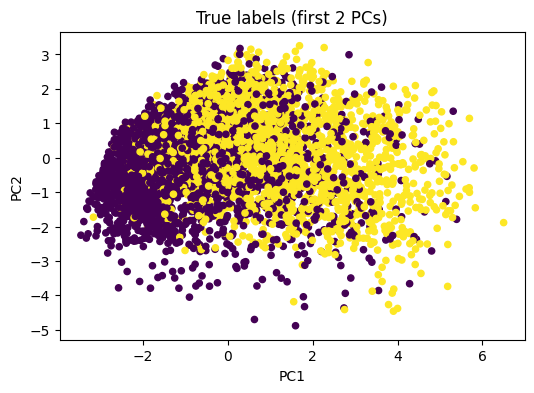

In [170]:
# Visualization: first two principal components
X_vis = X_reduced[:, :2]
plt.figure(figsize=(6,4))
plt.scatter(X_vis[:,0], X_vis[:,1], c=y_true, s=20)
plt.title('True labels (first 2 PCs)')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

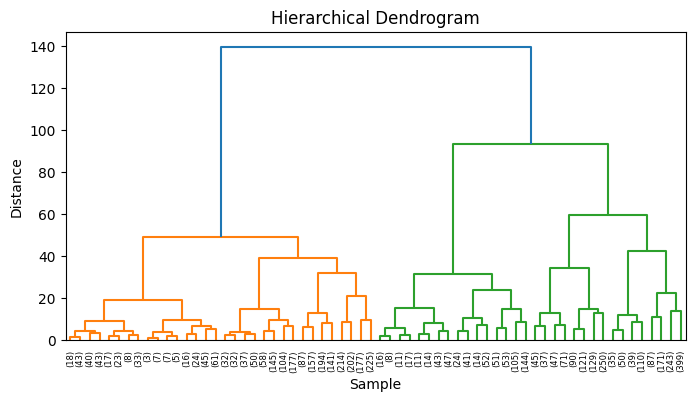

In [171]:
# Hierarchical clustering dendrogram
Z = linkage(X_reduced, method='ward')
plt.figure(figsize=(8,4))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Dendrogram')
plt.xlabel('Sample'); plt.ylabel('Distance'); plt.show()

In [174]:
#Hyperpatameter tuniing for DBSCAN, FuzzyCMeans, and GMM
# DBSCAN
best_db = {'sil': -np.inf, 'eps': None, 'min_samples': None}
eps_vals = np.linspace(0.001, 5.0, 100)
min_samples_list = [2,3,4,5,6,7,8,9,10]
for eps in eps_vals:
    for ms in min_samples_list:
        labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(X_reduced)
        clusters = set(labels) - {-1}
        if len(clusters) == N_CLUSTERS:
            sil = silhouette_score(X_reduced, labels)
            if sil > best_db['sil']:
                best_db.update({'sil': sil, 'eps': eps, 'min_samples': ms})
print(f"Tuned DBSCAN: eps={best_db['eps']:.3f}, min_samples={best_db['min_samples']} (silhouette={best_db['sil']:.3f})")

# Fuzzy C-Means
best_fcm = {'sil': -np.inf, 'm': None}
for m in np.arange(1.1, 10.1, 0.1):
    fcm = FCM(n_clusters=N_CLUSTERS, m=m)
    fcm.fit(X_reduced)
    labels = fcm.u.argmax(axis=1)
    sil = silhouette_score(X_reduced, labels)
    if sil > best_fcm['sil']:
        best_fcm.update({'sil': sil, 'm': m})
print(f"Tuned FuzzyCMeans: m={best_fcm['m']:.1f} (silhouette={best_fcm['sil']:.3f})")

# GMM tuning
best_gmm = {'sil': -np.inf, 'cov': None, 'reg': None}
cov_types = ['full','tied','diag','spherical']
reg_vals = [1e-6, 1e-4, 1e-2, 1e-1]
for cov in cov_types:
    for reg in reg_vals:
        try:
            labels = GaussianMixture(n_components=N_CLUSTERS, covariance_type=cov, random_state=42, reg_covar=reg).fit_predict(X_reduced)
            sil = silhouette_score(X_reduced, labels)
            if sil > best_gmm['sil']:
                best_gmm.update({'sil': sil, 'cov': cov, 'reg': reg})
        except:
            pass
print(f"Tuned GMM: cov_type={best_gmm['cov']}, reg_covar={best_gmm['reg']} (silhouette={best_gmm['sil']:.3f})")



Tuned DBSCAN: eps=0.607, min_samples=4 (silhouette=0.457)
Tuned FuzzyCMeans: m=1.1 (silhouette=0.448)
Tuned GMM: cov_type=tied, reg_covar=0.1 (silhouette=0.462)


# Best params found so far
* Tuned DBSCAN: eps=0.607, min_samples=4 (silhouette=0.457)
* Tuned FuzzyCMeans: m=1.1 (silhouette=0.448)
* Tuned GMM: cov_type=tied, reg_covar=0.1 (silhouette=0.462)

In [175]:
# Define clustering models with tuned parameters
models = [
    ('KMeans', KMeans(n_clusters=N_CLUSTERS, random_state=42)),
    ('Hierarchical', AgglomerativeClustering(n_clusters=N_CLUSTERS)),
    ('DBSCAN', DBSCAN(eps=best_db['eps'], min_samples=best_db['min_samples'])),
    ('FuzzyCMeans', FCM(n_clusters=N_CLUSTERS, m=best_fcm['m'])),
    ('GMM', GaussianMixture(n_components=N_CLUSTERS,
                             covariance_type=best_gmm['cov'],
                             random_state=42,
                             reg_covar=1e-3)),
    ('BIRCH', Birch(n_clusters=N_CLUSTERS))
]

results = []
labels_store = {}

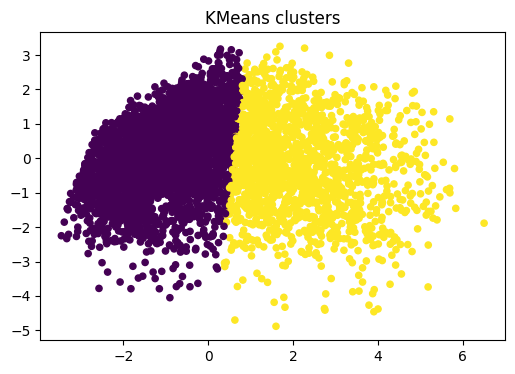

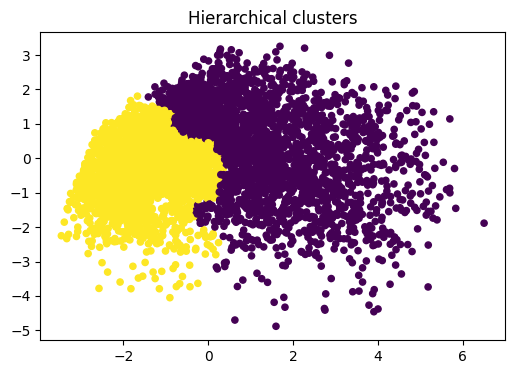

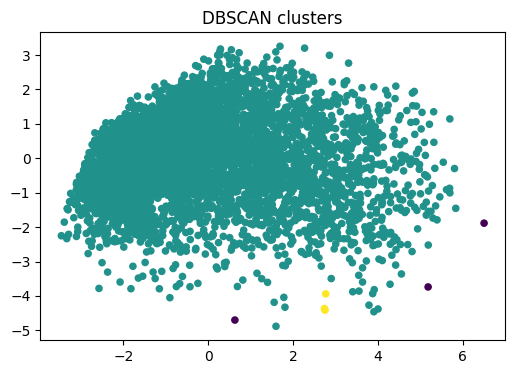

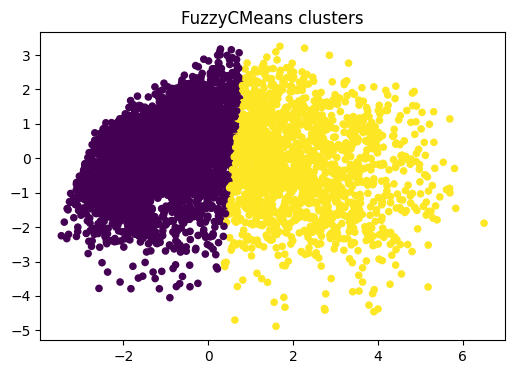

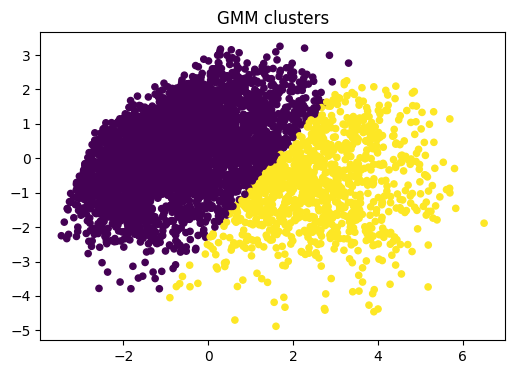

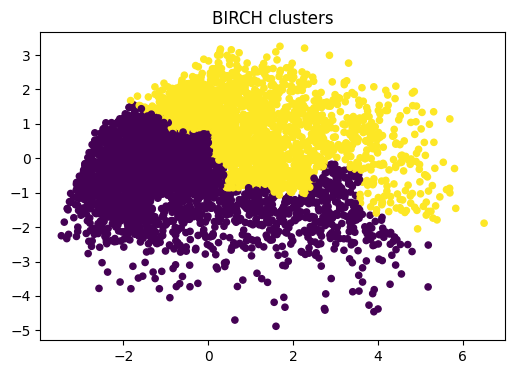

In [176]:
for name, model in models:
    if name == 'FuzzyCMeans':
        model.fit(X_reduced)
        labels = model.u.argmax(axis=1)
    elif name == 'GMM':
        labels = model.fit_predict(X_reduced)
    else:
        labels = model.fit_predict(X_reduced)
    labels_store[name] = labels
    plt.figure(figsize=(6,4))
    plt.scatter(X_vis[:,0], X_vis[:,1], c=labels, s=20)
    plt.title(f'{name} clusters'); plt.show()
    results.append({
        'Algorithm': name,
        'Silhouette': silhouette_score(X_reduced, labels),
        'Davies-Bouldin': davies_bouldin_score(X_reduced, labels),
        'ARI': adjusted_rand_score(y_true, labels),
        'NMI': normalized_mutual_info_score(y_true, labels)
    })

# Evaluation Score
* Silhouette: -1 to 1, Closer to 1 the better
* Davies-Bouldin: 0 to infinity, closer to 0 the better
* ARI: -1 to 1, Closer to 1 the better
* NMI 0 to 1, Closer to 1 the better

In [177]:
# Display evaluation table
metrics_df = pd.DataFrame(results)
display(metrics_df)

,Algorithm,Silhouette,Davies-Bouldin,ARI,NMI
0,KMeans,0.448178,0.903273,1.116563e-01,0.098684
1,Hierarchical,0.356723,1.038180,1.973309e-01,0.148047
2,DBSCAN,0.457490,1.449885,-2.805538e-07,0.000193
3,FuzzyCMeans,0.447650,0.904430,1.116562e-01,0.098315
4,GMM,0.460204,0.839875,4.615104e-02,0.058284
5,BIRCH,0.280445,1.376439,1.271345e-01,0.097800


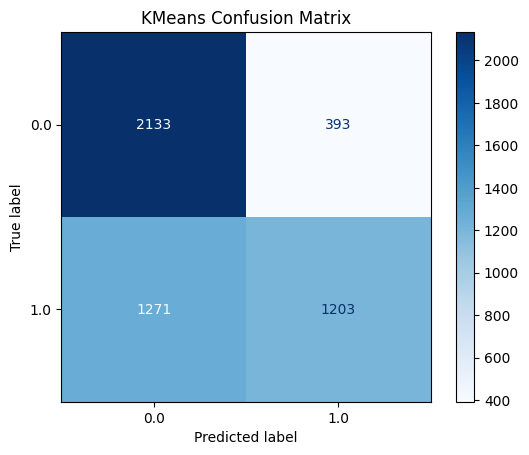

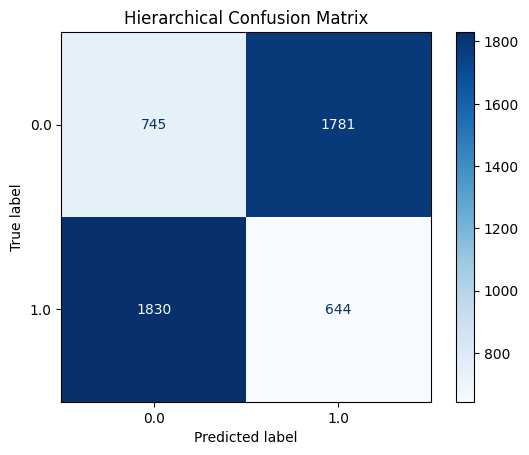

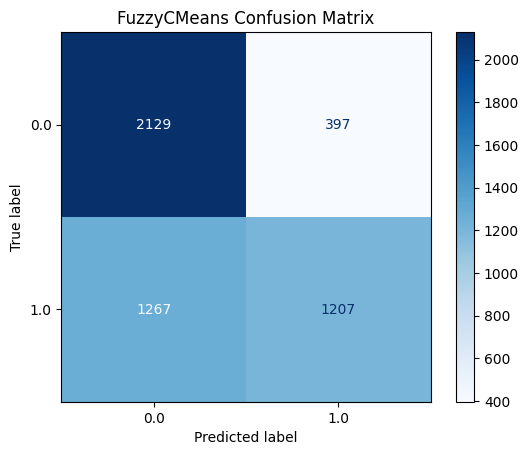

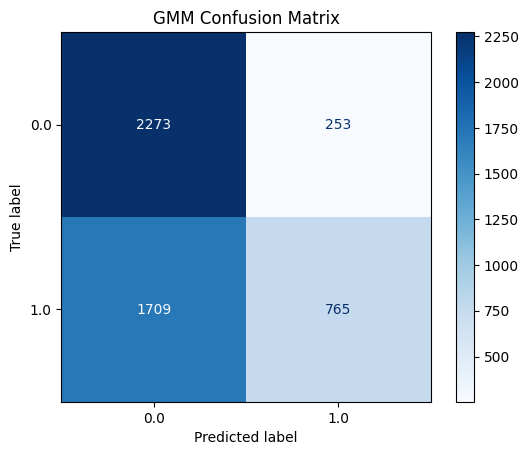

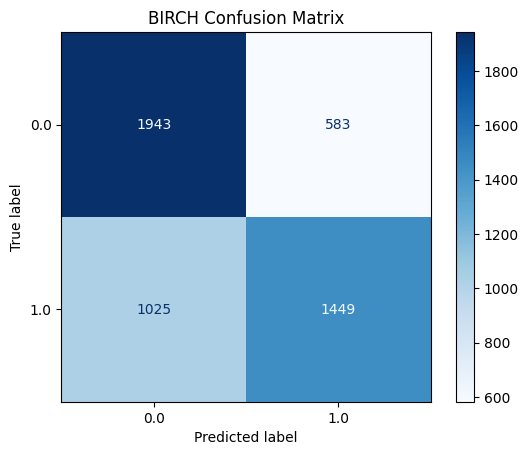

In [178]:
# Confusion matrices for valid models
for name, labels in labels_store.items():
    if len(np.unique(labels)) == N_CLUSTERS:
        ConfusionMatrixDisplay.from_predictions(
            y_true, labels,
            display_labels=np.unique(y_true),
            cmap='Blues'
        )
        plt.title(f'{name} Confusion Matrix'); plt.show()

In [179]:
# Summarize centroids and sizes
features_df = pd.DataFrame(X_reduced, columns=[f'PC{i+1}' for i in range(PCA_N)])
for name, labels in labels_store.items():
    if name == 'DBSCAN': continue
    features_df['cluster'] = labels
    summary = features_df.groupby('cluster').mean()
    summary['size'] = features_df.groupby('cluster').size()
    print(f"{name} centroids and sizes (in PC space):")
    display(summary.round(2))

KMeans centroids and sizes (in PC space):


,PC1,PC2,size
cluster,,,
0,-1.03,0.10,3404
1,2.19,-0.21,1596


Hierarchical centroids and sizes (in PC space):


,PC1,PC2,size
cluster,,,
0,1.33,0.29,2575
1,-1.41,-0.30,2425


FuzzyCMeans centroids and sizes (in PC space):


,PC1,PC2,size
cluster,,,
0,-1.03,0.1,3396
1,2.18,-0.2,1604


GMM centroids and sizes (in PC space):


,PC1,PC2,size
cluster,,,
0,-0.68,0.22,3982
1,2.68,-0.86,1018


BIRCH centroids and sizes (in PC space):


,PC1,PC2,size
cluster,,,
0,-0.74,-0.57,2968
1,1.08,0.84,2032


In [180]:
# Recommendations based on results
best_internal = metrics_df.loc[metrics_df['Silhouette'].idxmax(), 'Algorithm']
best_external = metrics_df.loc[metrics_df['ARI'].idxmax(), 'Algorithm']
print(f"Best internal algorithm: {best_internal}")
print(f"Best external algorithm: {best_external}")

Best internal algorithm: GMM
Best external algorithm: Hierarchical
